In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chaospy as ch
from scipy import integrate
import pandas as pd
from mpl_toolkits import mplot3d
import time
import json
import pickle
from IPython.display import Image
import pandas as pd
import datetime
import numpoly
from itertools import product
from collections import OrderedDict
from os import PathLike
import re
import os
import seaborn as sns

##SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
#Chaospy
import chaospy as ch

#EMA Workbench
import ema_workbench as em

from ema_workbench import (RealParameter, TimeSeriesOutcome, ema_logging,
                           MultiprocessingEvaluator, ScalarOutcome,
                           perform_experiments, CategoricalParameter,
                           save_results, Policy, )
from ema_workbench.connectors.vensim import (VensimModel, load_model, set_value, run_simulation, 
                                             get_data, be_quiet, vensimDLLwrapper)
from ema_workbench.connectors.vensim import load_model
from ema_workbench.em_framework.evaluators import SequentialEvaluator

def c(a):
    os.chdir(a)
    return os.getcwd()




C:\Users\jeffr\Anaconda3\envs\gds\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\jeffr\Anaconda3\envs\gds\lib\site-packages\ema_workbench\connectors\__init__.py:27: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


In [3]:

#Parameters & initial_conditions




x0 = 33                                                               #Initial conditions same as before
y0 = 6.2                       
X = [x0,y0]
t = np.linspace(0., 30, 1000)

#Model

def lotka(X, t, alpha, beta, delta, gamma):
    x, y = X
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)
    return np.array([dotx, doty])

#Parameter space


problem = {
    'num_vars': 7,
    'names': ['alpha','beta','delta','gamma','e','f','h'],
    'bounds': [[0.44,0.68],
               [0.02,0.044],
               [0.71,1.15],
               [0.0226,0.0354],
               [0.03,0.055],
               [0.71,1.15],
               [0.0354,0.0482]]
}

##Parameters
alpha = ch.Uniform(0.44, 0.68) #We choose uniform distributions to reflect our lack of knowledge about the relative likelihood functions
beta = ch.Uniform(0.02, 0.044) #We take the same bounds as for the Sobol-Saltelli analysis
delta = ch.Uniform(0.71, 1.15)
gamma = ch.Uniform(0.0226, 0.0354)

joint = ch.J(alpha,beta,delta,gamma) #The input paramter distributions are assumed to be independent so we may easily construct the joint input probability distribution.

##Expansion
expansion = ch.generate_expansion(2, joint) #Here we generate the polynomial expansion which is truncated a maximum mixed order of 2.



In [ ]:
x0 = 0.5
y0 = 1
z0 = 2
X = (x0,y0,z0)
t = np.linspace(0,30,1000)

problem = { ## These are the values for which we have truly crazy multimodal owl populations
    'num_vars': 7,
    'names': ['alpha','beta','delta','gamma','e','f','h'],
    'bounds': [[0.44,0.68],
               [0.02,0.044],
               [0.71,1.15],
               [0.0226,0.0354],
               [0.03,0.055],
               [0.71,1.15],
               [0.02,0.03]]}

def lotka3(X,t,a,b,d,g,e,f,h):
    x, y, z = X
    dotx = x * (a - b * y)
    doty = y * (-d + (g * x) - e * z) 
    dotz = z * (-f + h*y)
    return np.array([dotx, doty, dotz])

distributions = []

for idx,name in enumerate(problem['names']):
    a,b = problem['bounds'][idx]
    distributions.append(ch.Uniform(a,b))
    
joint = ch.J(*distributions)

    

joint
    
    

## Test of github workaround   

> Implement function with code. 

> Test for fitted polynomial + time tests

In [18]:
## function

def sense(dim,poly,uhat):
    variance = np.sum(uhat[1:]**2)
    main = np.zeros(dim)
    total = np.zeros(dim)
    
    for idx, pol in enumerate(poly.exponents[1:]):
        add_total = [False,]*dim
        add_main = [True,]*dim
        for var in range(4):
            if pol[var] > 0:
                add_total[var] = True
                add_main[var] = add_main[var] and True
                add_main[0:var] = [False,]*var
                try:
                    add_main[var+1::] = [False,]*(dim-var)
                except IndexError:
                    pass
        for var in range(4):
            if add_main[var]:
                main[var] += uhat[idx+1]**2
            if add_total[var]:
                total[var] += uhat[idx+1]**2
    
    
    s1 = main/variance
    st = total/variance
    
    return s1,st
    
    

In [110]:
nodes,weights= ch.generate_quadrature(4,joint,rule='g')


In [112]:
nodes

array([[0.45125842, 0.45125842, 0.45125842, ..., 0.66874158, 0.66874158,
        0.66874158],
       [0.02112584, 0.02112584, 0.02112584, ..., 0.04287416, 0.04287416,
        0.04287416],
       [0.73064043, 0.73064043, 0.73064043, ..., 1.12935957, 1.12935957,
        1.12935957],
       [0.02320045, 0.0255538 , 0.029     , ..., 0.029     , 0.0324462 ,
        0.03479955]])

In [171]:
## generate test polynomial
expansion,norms = ch.generate_expansion(2,joint,normed=True,retall=True)
nodes,weights= ch.generate_quadrature(4,joint,rule='g')
#samples = joint.sample(2000,rule='sobol').T
evals = []
dick = {}

for node in nodes.T:
    
    if tuple(node) in dick.keys():
        a,b,d,g = node
        solution = dick[tuple(node)]
        evals.append(solution)
    
    else:  
        a,b,d,g = node
        solution = integrate.odeint(lotka,X,t,args=(a,b,d,g)).T[0][910]
        dick[tuple(node)] = solution
        evals.append(solution)


In [172]:
expansion.exponents

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]], dtype=uint32)

In [5]:
gt = pd.read_csv('./data/indices_328000_GT.csv').ST
gt

0    0.432888
1    0.111063
2    0.778830
3    0.095090
Name: ST, dtype: float64

In [176]:
poly,uhat = ch.fit_quadrature(expansion,nodes,weights,evals,retall=1)

In [155]:
numpoly.decompose(poly)

polynomial([-115.11176438863038, -826.9829560178794*q3,
            107.88619559270464*q2, 278.35522922873224*q1,
            111.74090583413101*q0])

In [177]:
uhat

array([ 3.27221664e+01, -3.05573653e+00,  1.37033873e+01,  1.92850160e+00,
        7.74163705e+00, -1.59015907e-02, -1.44520891e+00, -4.92664581e-01,
       -6.60987648e-01, -1.93308764e+00, -6.55998183e-01, -1.96761168e+00,
        3.64007714e+00, -1.07687963e+00, -2.02710629e-01])

In [179]:
new = (uhat[1:])[::-1]
new

array([-0.20271063, -1.07687963,  3.64007714, -1.96761168, -0.65599818,
       -1.93308764, -0.66098765, -0.49266458, -1.44520891, -0.01590159,
        7.74163705,  1.9285016 , 13.70338729, -3.05573653])

In [182]:
uhat

array([ 3.27221664e+01, -3.05573653e+00,  1.37033873e+01,  1.92850160e+00,
        7.74163705e+00, -1.59015907e-02, -1.44520891e+00, -4.92664581e-01,
       -6.60987648e-01, -1.93308764e+00, -6.55998183e-01, -1.96761168e+00,
        3.64007714e+00, -1.07687963e+00, -2.02710629e-01])

In [162]:
coeffs=uhat[1:]
coeffs

array([-3.05573653, 13.70338729,  1.9285016 ,  7.74163705])

In [168]:
new = coeffs[::-1]

In [181]:
(new**2)/varr

array([1.57576481e-04, 4.44705681e-03, 5.08112092e-02, 1.48462627e-02,
       1.65022677e-03, 1.43298433e-02, 1.67542520e-03, 9.30767129e-04,
       8.00939327e-03, 9.69660036e-07, 2.29828546e-01, 1.42619320e-02,
       7.20102338e-01, 3.58071840e-02])

In [190]:
test = numpoly.decompose(poly)
test[1].exponents

array([[0],
       [1]], dtype=uint32)

In [192]:
test

polynomial([-296.64059704935073, 7242.656859277623*q3,
            -1302.1376111794145*q3**2, 99.34128701546337*q2,
            -3079.280351422173*q2*q3, -34.141471867401485*q2**2,
            5304.3163773728775*q1, -25819.829995221215*q1*q3,
            -2196.690495366813*q1*q2, -15279.755519497032*q1**2,
            74.61847497556685*q0, -7685.983119959636*q0*q3,
            413.64512909569487*q0*q2, -2243.499222042472*q0*q1,
            -47.216119300217386*q0**2])

In [187]:
for i in numpoly.decompose(poly):
    print(i)

-296.64059704935073
7242.656859277623*q3
-1302.1376111794145*q3**2
99.34128701546337*q2
-3079.280351422173*q2*q3
-34.141471867401485*q2**2
5304.3163773728775*q1
-25819.829995221215*q1*q3
-2196.690495366813*q1*q2
-15279.755519497032*q1**2
74.61847497556685*q0
-7685.983119959636*q0*q3
413.64512909569487*q0*q2
-2243.499222042472*q0*q1
-47.216119300217386*q0**2


In [186]:
poly.exponents

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]], dtype=uint32)

In [180]:
ch.Sens_m(poly,joint)

array([0.20967707, 0.01450703, 0.65736187, 0.03264609])

In [175]:
var = ch.Var(poly,joint)
varr = np.sum(uhat[1:]**2)
var,varr

(array(260.77241166), 260.7724116615531)

In [118]:
expansion.exponents

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]], dtype=uint32)

In [104]:
test = np.zeros((10,10))
test

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [408]:
import numpy
import numpoly


def fit_quadrature(orth, nodes, weights, solves, retall=False, norms=None):
    """
    Fit polynomial chaos expansion using spectral projection.

    Create a polynomial approximation model from orthogonal expansion,
    quadrature nodes and weights.

    Args:
        orth (numpoly.ndpoly):
            Orthogonal polynomial expansion. Must be orthogonal for the
            approximation to be accurate.
        nodes (numpy.ndarray):
            Where to evaluate the polynomial expansion and model to
            approximate. ``nodes.shape==(D, K)`` where ``D`` is the number of
            dimensions and ``K`` is the number of nodes.
        weights (numpy.ndarray):
            Weights when doing numerical integration. ``weights.shape == (K,)``
            must hold.
        solves (numpy.ndarray):
            The model evaluation to approximate. If `numpy.ndarray` is
            provided, it must have ``len(solves) == K``.
        retall (int):
            What the function should return.
            0: only return fitted polynomials, with shape `evals.shape[1:]`.
            1: polynomials, and Fourier coefficients,
            2: polynomials, coefficients and polynomial evaluations.
        norms (numpy.ndarray):
            Three terms recurrence method produces norms more stable than the
            ones calculated from the polynomials themselves. Calculated from
            quadrature if not provided. ``norms.shape == (len(orth),)`` must
            hold.

    Returns:
        (numpoly.ndpoly):
            Fitted model approximation in the form of an polynomial.
    """
    global coeffs,vals1,ovals
    orth = numpoly.polynomial(orth)
    assert orth.ndim == 1
    weights = numpy.asfarray(weights)
    assert weights.ndim == 1
    solves = numpy.asfarray(solves)
    nodes = numpy.atleast_2d(nodes)
    assert nodes.ndim == 2
    assert nodes.shape[1] == len(weights) == len(solves)

    shape = solves.shape[1:]
    solves = solves.reshape(len(solves), -1)

    ovals = orth(*nodes)
    vals1 = [(val * solves.T * weights).T for val in ovals]

    if norms is None:
        norms = numpy.sum(ovals**2 * weights, -1)
    norms = numpy.asfarray(norms)
    assert norms.ndim == 1

    coeffs = (numpy.sum(vals1, 1).T / norms).T
    #coeffs = coeffs.reshape(len(coeffs), *shape)
    #approx_model = numpoly.sum(orth * coeffs.T, -1).T

    return coeffs

## Begin again in earnest

In [563]:
expansion = ch.generate_expansion(3,joint,normed=True)
expansion

polynomial([1.0, 14.433756729740642*q0-8.08290376865476,
            7.87295821622217*q2-7.321851141086618,
            144.33756729740645*q1-4.618802153517007,
            270.632938682637*q3-7.848355221796473,
            81887.25503539266*q3**2-4749.460792052774*q3+67.74914749601533,
            113.63636363636363*q0*q2-63.636363636363626*q2-105.68181818181816*q0+59.18181818181817,
            23292.374765622815*q1**2-1490.7119849998603*q1+22.733357771247867,
            2083.333333333333*q0*q1-1166.6666666666665*q1-66.66666666666667*q0+37.33333333333333,
            1136.3636363636365*q1*q2-36.36363636363637*q2-1056.818181818182*q1+33.81818181818182,
            39062.49999999999*q1*q3-1250.0*q3-1132.8124999999998*q1+36.24999999999999,
            3906.2499999999986*q0*q3-2187.499999999999*q3-113.28124999999996*q0+63.43749999999997,
            232.923747656228*q0**2-260.8745973749754*q0+71.92685327624321,
            69.299627401853*q2**2-128.89730696744658*q2+58.819213751112756,


In [565]:
exponents = ch.lead_exponent(expansion)
exponents.shape

(35, 4)

In [420]:
pairs = [i for i in zip(expansion,uhat)]

In [546]:
table = pd.DataFrame(columns=['term','exponent','coeff'])
table.term = [i for i in expansion]
table.coeff = [i for i in uhat]
table.exponent = [i for i in ch.lead_exponent(expansion,graded=True)]
table

,term,exponent,coeff
0,1.0,"[0, 0, 0, 0]",32.723033
1,270.632938682637*q3-7.848355221796473,"[0, 0, 0, 1]",-3.056561
2,14.433756729740642*q0-8.08290376865476,"[1, 0, 0, 0]",7.741511
3,7.87295821622217*q2-7.321851141086618,"[0, 0, 1, 0]",13.707078
4,144.33756729740645*q1-4.618802153517007,"[0, 1, 0, 0]",1.928021
...,...,...,...
205,25238258695.69994*q0*q2**2*q3**3-2195728506.52...,"[1, 0, 2, 3]",-0.046097
206,888989730314.7744*q0*q2*q3**4-497834248976.273...,"[1, 0, 1, 4]",-0.011130
207,35109643235714.9*q0*q3**5-19661400212000.344*q...,"[1, 0, 0, 5]",0.004996
208,8482859172721.368*q0*q1**2*q3**3-738008748026....,"[1, 2, 0, 3]",0.005948


In [530]:
table.iloc[66]

term        9305369.890385529*q0*q2*q3**2-5211007.13861589...
exponent                                         [1, 0, 1, 2]
coeff                                                 0.63765
Name: 66, dtype: object

In [534]:
ch.Var(poly,joint),np.sum(np.array(table.coeff)[1:]**2)


(array(375.850919), 375.85091186052233)

In [488]:
arr = table.exponent[12]
arr

array([1, 0, 1, 0])

In [487]:
mask

array([0., 1., 1., 1.])

In [489]:
mask = np.ones(4)
mask[0] = False
result = arr*mask
result

array([0., 0., 1., 0.])

In [500]:
var = 0
table.exponent[4]

array([1, 0, 0, 0])

In [502]:
mask=np.ones(4)
mask[0] = False
mask

array([0., 1., 1., 1.])

In [508]:
np.all(table.exponent[idx]*mask == 0)

True

In [507]:
table.exponent[4]*mask

array([0., 0., 0., 0.])

In [506]:
table.exponent[4][0] 

1

In [498]:
for variable,name in enumerate(expansion.names):
    print(variable,name)

0 q0
1 q1
2 q2
3 q3


In [552]:
# first orders

s1 = {key:0 for key in expansion.names}
mask=np.ones(4)
variance = np.sum(np.array(table.coeff)[1:]**2)
for variable,name in enumerate(expansion.names):
    mask=np.ones(4)
    mask[variable] = False
    for idx in table.index:
        if table.exponent[idx][variable] > 0 and np.all(table.exponent[idx]*mask == 0):
            s1[name] += table.coeff[idx]**2
            
for key in s1.keys():
    s1[key] = s1[key]/variance
    
s1.values()
    
            


    


dict_values([0.1617472231541522, 0.010806670582910282, 0.49843147325755677, 0.02420048234990948])

In [537]:
import timeit

In [561]:
exponents = ch.lead_exponent(expansion,graded=True)
len(exponents)

35

In [554]:
exponents = ch.lead_exponent(expansion,graded=True)

def sense_main(uhat):
    dim = len(joint)
    s1 = np.zeros(dim)
    
    variance = np.sum(np.array(uhat[1:])**2)
    
    for variable,name in enumerate(expansion.names):
        mask = np.ones(dim)
        mask[variable] = False
        
        for idx,exponent in enumerate(exponents):
            if exponent[variable] > 0 and np.all(exponent*mask == 0):
                s1[variable] += uhat[idx]**2
                
    s1 = s1 / variance
    
    return s1



array([0.16174722, 0.01080667, 0.49843147, 0.02420048])

In [558]:
def sense_t(uhat):
    
    dim = len(joint)
    st = np.zeros(dim)
    
    variance = np.sum(np.array(uhat[1:])**2)
    
    for variable,name in enumerate(expansion.names):
        mask = np.ones(dim)
        mask[variable] = False
        
        for idx,exponent in enumerate(exponents):
            if exponent[variable] > 0 and np.all(exponent*mask == 0):
                st[variable] += uhat[idx]**2
                
            if exponent[variable] > 0 and np.any(exponent*mask != 0):
                st[variable] += uhat[idx]**2
                
    st = st / variance
    
    return st

sense_t(uhat)
    
    

array([0.42721641, 0.10427126, 0.77728951, 0.09135918])

In [557]:
# total orders
start = time.perf_counter()
st = {key:0 for key in expansion.names}

variance = np.sum(np.array(table.coeff)[1:]**2)

for variable,name in enumerate(expansion.names):
    mask=np.ones(4)
    mask[variable] = False
    for idx in table.index:
        if table.exponent[idx][variable] > 0 and np.all(table.exponent[idx]*mask == 0):
            st[name] += table.coeff[idx]**2

        if table.exponent[idx][variable] > 0 and np.any(table.exponent[idx]*mask != 0):
            st[name] += table.coeff[idx]**2
            
for key in st.keys():
    st[key] = st[key] / variance
    #st[key] = st[key] + s1[key]
    
st.values()
#print('Improved algorithm >>>',time.perf_counter() - start,'seconds')
            
    

dict_values([0.42721640758293095, 0.1042712581976962, 0.7772895070887207, 0.09135918259212956])

In [549]:
start = time.perf_counter()
ch.Sens_t(poly,joint)
print('Old algorithm >>>', time.perf_counter() - start,'seconds')

Old algorithm >>> 281.8501335000037 seconds


In [464]:
numpoly.glexsort(expansion,graded=True)

FeatureNotSupported: function 'lexsort' not supported by numpoly.

In [474]:
ch.lead_exponent(table.term[1],graded=True)

array([1])

In [467]:
s1 = {key:0 for key in expansion.names}

for term


{'q0': 0, 'q1': 0, 'q2': 0, 'q3': 0}

In [445]:
test = table.term[1]
test

polynomial(270.632938682637*q3-7.848355221796473)

In [446]:
test.exponents

array([[0],
       [1]], dtype=uint32)

In [441]:
(table.coeff[4]**2 + table.coeff[14]**2) / var

0.1360286946749956

In [431]:
s1_true = ch.Sens_m(poly,joint)
s1_true

array([0.13602869, 0.45538311, 0.0200298 , 0.3885584 ])

In [430]:
var = np.sum(uhat[1:]**2)

In [421]:
pairs


[(polynomial(1.0), 33.05030935450111),
 (polynomial(270.632938682637*q3-7.848355221796473), -3.7670078435831837),
 (polynomial(7.87295821622217*q2-7.321851141086618), 16.3320035869493),
 (polynomial(144.33756729740645*q1-4.618802153517007), 0.493371050714821),
 (polynomial(14.433756729740642*q0-8.08290376865476), 9.769479722541567),
 (polynomial(81887.25503539266*q3**2-4749.460792052774*q3+67.74914749601533),
  -5181576750439803.0),
 (polynomial(2130.6818181818176*q2*q3-1981.5340909090905*q3-61.78977272727271*q2+57.46448863636362),
  -1.8844003987871119),
 (polynomial(69.299627401853*q2**2-128.89730696744658*q2+58.819213751112756),
  -1176446181640815.8),
 (polynomial(39062.49999999999*q1*q3-1250.0*q3-1132.8124999999998*q1+36.24999999999999),
  -1.3949884049396943),
 (polynomial(1136.3636363636365*q1*q2-36.36363636363637*q2-1056.818181818182*q1+33.81818181818182),
  -3.340760421478166),
 (polynomial(23292.374765622815*q1**2-1490.7119849998603*q1+22.733357771247867),
  -5609475354504839

In [545]:
nodes,weights = ch.generate_quadrature(6,joint,rule='g')
evals = []

for node in nodes.T:
    
    if tuple(node) in dick.keys():
        a,b,d,g = node
        solution = dick[tuple(node)]
        evals.append(solution)
        
    else:
        a,b,d,g = node
        solution = integrate.odeint(lotka,X,t,args=(a,b,d,g)).T[0][910]
        evals.append(solution)
        
poly,uhat = ch.fit_quadrature(expansion,nodes,weights,evals,retall=True)
poly

polynomial(102790408440.75717*q3**6+44197387.389594786*q0**3*q2**2*q3+8076880.624200722*q0**5*q3+130996628.16457076*q0**4*q1*q3-1787902868.630998*q0**3*q1**2*q3-13983540442.085121*q0**2*q1**3*q3+14273978130.493898*q0*q1**4*q3+70885557302.42242*q2*q3**5+47559175.59263108*q0**4*q2*q3+582969428.6420288*q0**3*q1*q2*q3+524532492.32868373*q0**2*q1**2*q2*q3-10369487051.334625*q0*q1**3*q2*q3+7099583553.606969*q1**4*q2*q3+492738406.6447245*q0**2*q1*q2**2*q3+432697.8133020941*q1*q2**5+617719996.3444645*q0*q1**2*q2**2*q3-4329260319.37623*q1**3*q2**2*q3+22846459.625772975*q0**2*q2**3*q3+218818298.13159722*q0*q1*q2**3*q3-135701169.21997136*q1**2*q2**3*q3+8527721.440809432*q0*q2**4*q3+34327121.610286735*q1*q2**4*q3+1150925.623725201*q2**5*q3-223896394.46609557*q0**4*q3**2-3524581044.6662035*q0**3*q1*q3**2-26033511542.85903*q0**2*q1**2*q3**2+17990.87802448877*q2**6+250631.72047408795*q0*q2**5+205036231728.85168*q1**4*q3**2-3210252704.533667*q0*q1**4*q2+800334.6503643973*q0**6+11214598.575682748*q0**5

In [412]:
coeffs = fit_quadrature(expansion,nodes,weights,evals,retall=True)
coeffs

array([[33.05030935],
       [-3.76700784],
       [16.33200359],
       [ 0.49337105],
       [ 9.76947972]])

In [414]:
shape = solves.shape[1:]
new = coeffs.reshape(len(coeffs), *shape)

In [415]:
new

array([[33.05030935],
       [-3.76700784],
       [16.33200359],
       [ 0.49337105],
       [ 9.76947972]])

In [357]:
solves = np.asfarray(evals)
solves

array([14.55467672,  9.64724608, 27.74578959, 29.29412348, 18.47845206,
       13.25933628, 35.90714342, 37.35986943, 14.76444526, 12.57032912,
       82.65091939, 69.22797678, 26.60607881, 23.86588181, 73.83103233,
       39.04164911])

In [369]:
test = nodes[0]
ovals = numpoly.polynomial(expansion(*nodes))


In [376]:
solves

array([14.55467672,  9.64724608, 27.74578959, 29.29412348, 18.47845206,
       13.25933628, 35.90714342, 37.35986943, 14.76444526, 12.57032912,
       82.65091939, 69.22797678, 26.60607881, 23.86588181, 73.83103233,
       39.04164911])

In [375]:
a,b,d,g = nodes.T[3]
expansion(a,b,d,g)

array([ 1.,  1.,  1., -1., -1.])

In [405]:
p = [(val * solves.T * weights).T for val in ovals]
p

[polynomial([[0.9096672950417265],
             [0.6029528800630746],
             [1.7341118496112997],
             [1.8308827175992526],
             [1.1549032535631154],
             [0.8287085172675313],
             [2.244196463759164],
             [2.3349918390746174],
             [0.9227778287846342],
             [0.7856455699502899],
             [5.16568246216987],
             [4.326748548672984],
             [1.662879925697526],
             [1.491617613407985],
             [4.614439520414787],
             [2.440103069423224]]),
 polynomial([[-0.9096672950417265],
             [0.602952880063074],
             [-1.7341118496112997],
             [1.830882717599251],
             [-1.1549032535631154],
             [0.8287085172675305],
             [-2.244196463759164],
             [2.334991839074615],
             [-0.9227778287846342],
             [0.7856455699502892],
             [-5.16568246216987],
             [4.32674854867298],
             [-1.66287992569

In [ ]:
vals1 = [(val * solves.T * weights).T for val in ovals]

In [406]:
np.sum(p,1).T

TypeError: cannot perform reduce with flexible type

In [395]:
uhat

array([33.05030935, -3.76700784, 16.33200359,  0.49337105,  9.76947972])

In [378]:
solves = solves.reshape(len(solves), -1)
solves.T

array([[14.55467672,  9.64724608, 27.74578959, 29.29412348, 18.47845206,
        13.25933628, 35.90714342, 37.35986943, 14.76444526, 12.57032912,
        82.65091939, 69.22797678, 26.60607881, 23.86588181, 73.83103233,
        39.04164911]])

In [360]:
expansion,norms = ch.generate_expansion(1,joint,normed=True,retall=True)
expansion,norms

(polynomial([1.0, 270.632938682637*q3-7.848355221796473,
             7.87295821622217*q2-7.321851141086618,
             144.33756729740645*q1-4.618802153517007,
             14.433756729740642*q0-8.08290376865476]),
 array([1., 1., 1., 1., 1.]))

In [347]:
nodes

array([[0.49071797, 0.49071797, 0.49071797, 0.49071797, 0.49071797,
        0.49071797, 0.49071797, 0.49071797, 0.62928203, 0.62928203,
        0.62928203, 0.62928203, 0.62928203, 0.62928203, 0.62928203,
        0.62928203],
       [0.0250718 , 0.0250718 , 0.0250718 , 0.0250718 , 0.0389282 ,
        0.0389282 , 0.0389282 , 0.0389282 , 0.0250718 , 0.0250718 ,
        0.0250718 , 0.0250718 , 0.0389282 , 0.0389282 , 0.0389282 ,
        0.0389282 ],
       [0.80298294, 0.80298294, 1.05701706, 1.05701706, 0.80298294,
        0.80298294, 1.05701706, 1.05701706, 0.80298294, 0.80298294,
        1.05701706, 1.05701706, 0.80298294, 0.80298294, 1.05701706,
        1.05701706],
       [0.02530496, 0.03269504, 0.02530496, 0.03269504, 0.02530496,
        0.03269504, 0.02530496, 0.03269504, 0.02530496, 0.03269504,
        0.02530496, 0.03269504, 0.02530496, 0.03269504, 0.02530496,
        0.03269504]])

In [348]:
numpy.atleast_2d(nodes) == nodes

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]])

In [350]:
nodes,weights = ch.generate_quadrature(1,joint,rule='g')
evals = []

for node in nodes.T:
    
    if tuple(node) in dick.keys():
        a,b,d,g = node
        solution = dick[tuple(node)]
        evals.append(solution)
        
    else:
        a,b,d,g = node
        solution = integrate.odeint(lotka,X,t,args=(a,b,d,g)).T[0][910]
        evals.append(solution)
        
poly,uhat = fit_quadrature(expansion,nodes,weights,evals,retall=True)

AttributeError: 'list' object has no attribute 'shape'

In [335]:
len(evals)

16

In [325]:
st_true= (ch.Sens_m(poly,joint))
st_true

array([0.21258097, 0.01784185, 0.66578494, 0.03191474])

In [274]:
numpoly.lead_exponent(expansion,graded=True)

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 2],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]])

In [260]:
s1_true = ch.Sens_m(poly,joint)
s1_true

array([0.22960802, 0.01784323, 0.71805044, 0.03449831])

In [261]:
coeffs = uhat[1:]
coeffs = coeffs**2
var = np.sum(coeffs)

In [263]:
(coeffs/var)[::-1]

array([0.22960802, 0.01784323, 0.71805044, 0.03449831])

In [223]:
len(vals1)

15

In [248]:
expansion

polynomial([1.0, 270.632938682637*q3-7.848355221796473,
            7.87295821622217*q2-7.321851141086618,
            144.33756729740645*q1-4.618802153517007,
            14.433756729740642*q0-8.08290376865476,
            81887.25503539266*q3**2-4749.460792052774*q3+67.74914749601533,
            2130.6818181818176*q2*q3-1981.5340909090905*q3-61.78977272727271*q2+57.46448863636362,
            69.299627401853*q2**2-128.89730696744658*q2+58.819213751112756,
            39062.49999999999*q1*q3-1250.0*q3-1132.8124999999998*q1+36.24999999999999,
            1136.3636363636365*q1*q2-36.36363636363637*q2-1056.818181818182*q1+33.81818181818182,
            23292.374765622815*q1**2-1490.7119849998603*q1+22.733357771247867,
            3906.2499999999986*q0*q3-2187.499999999999*q3-113.28124999999996*q0+63.43749999999997,
            113.63636363636363*q0*q2-63.636363636363626*q2-105.68181818181816*q0+59.18181818181817,
            2083.333333333333*q0*q1-1166.6666666666665*q1-66.6666666666666

In [249]:
expansion.exponents

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]], dtype=uint32)

In [247]:
uhat

array([ 3.27221664e+01, -3.05573653e+00,  1.37033873e+01,  1.92850160e+00,
        7.74163705e+00, -1.59015907e-02, -1.44520891e+00, -4.92664581e-01,
       -6.60987648e-01, -1.93308764e+00, -6.55998183e-01, -1.96761168e+00,
        3.64007714e+00, -1.07687963e+00, -2.02710629e-01])

In [227]:
numpoly.polynomial(expansion)

polynomial([1.0, 270.632938682637*q3-7.848355221796473,
            7.87295821622217*q2-7.321851141086618,
            144.33756729740645*q1-4.618802153517007,
            14.433756729740642*q0-8.08290376865476,
            81887.25503539266*q3**2-4749.460792052774*q3+67.74914749601533,
            2130.6818181818176*q2*q3-1981.5340909090905*q3-61.78977272727271*q2+57.46448863636362,
            69.299627401853*q2**2-128.89730696744658*q2+58.819213751112756,
            39062.49999999999*q1*q3-1250.0*q3-1132.8124999999998*q1+36.24999999999999,
            1136.3636363636365*q1*q2-36.36363636363637*q2-1056.818181818182*q1+33.81818181818182,
            23292.374765622815*q1**2-1490.7119849998603*q1+22.733357771247867,
            3906.2499999999986*q0*q3-2187.499999999999*q3-113.28124999999996*q0+63.43749999999997,
            113.63636363636363*q0*q2-63.636363636363626*q2-105.68181818181816*q0+59.18181818181817,
            2083.333333333333*q0*q1-1166.6666666666665*q1-66.6666666666666

In [213]:
a = (numpy.sum(vals1,1).T/norms).T
a = a.reshape(len(a))
a

array([ 3.27221664e+01, -3.05573653e+00,  1.37033873e+01,  1.92850160e+00,
        7.74163705e+00, -1.59015907e-02, -1.44520891e+00, -4.92664581e-01,
       -6.60987648e-01, -1.93308764e+00, -6.55998183e-01, -1.96761168e+00,
        3.64007714e+00, -1.07687963e+00, -2.02710629e-01])

In [207]:
fit_quadrature(expansion,nodes,weights,evals)


array([[ 3.27221664e+01],
       [-3.05573653e+00],
       [ 1.37033873e+01],
       [ 1.92850160e+00],
       [ 7.74163705e+00],
       [-1.59015907e-02],
       [-1.44520891e+00],
       [-4.92664581e-01],
       [-6.60987648e-01],
       [-1.93308764e+00],
       [-6.55998183e-01],
       [-1.96761168e+00],
       [ 3.64007714e+00],
       [-1.07687963e+00],
       [-2.02710629e-01]])

In [230]:
uhat

array([ 3.27221664e+01, -3.05573653e+00,  1.37033873e+01,  1.92850160e+00,
        7.74163705e+00, -1.59015907e-02, -1.44520891e+00, -4.92664581e-01,
       -6.60987648e-01, -1.93308764e+00, -6.55998183e-01, -1.96761168e+00,
        3.64007714e+00, -1.07687963e+00, -2.02710629e-01])

In [231]:
poly

polynomial(-1302.1376111794145*q3**2-3079.280351422173*q2*q3-25819.829995221215*q1*q3-7685.983119959636*q0*q3-34.141471867401485*q2**2-2196.690495366813*q1*q2+413.64512909569487*q0*q2-15279.755519497032*q1**2-2243.499222042472*q0*q1-47.216119300217386*q0**2+7242.656859277623*q3+99.34128701546337*q2+5304.3163773728775*q1+74.61847497556685*q0-296.64059704935073)

In [233]:
poly.exponents

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]], dtype=uint32)

In [240]:
numpoly.decompose(expansion)

polynomial([[1.0, -7.848355221796473, -7.321851141086618,
             -4.618802153517007, -8.08290376865476, 67.74914749601533,
             57.46448863636362, 58.819213751112756, 36.24999999999999,
             33.81818181818182, 22.733357771247867, 63.43749999999997,
             59.18181818181817, 37.33333333333333, 71.92685327624321],
            [0.0, 270.632938682637*q3, 0.0, 0.0, 0.0,
             -4749.460792052774*q3, -1981.5340909090905*q3, 0.0,
             -1250.0*q3, 0.0, 0.0, -2187.499999999999*q3, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 81887.25503539266*q3**2, 0.0, 0.0,
             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 7.87295821622217*q2, 0.0, 0.0, 0.0,
             -61.78977272727271*q2, -128.89730696744658*q2, 0.0,
             -36.36363636363637*q2, 0.0, 0.0, -63.636363636363626*q2,
             0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2130.6818181818176*q2*q3, 0.0,
             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  

In [239]:
(uhat[-1]+uhat[10])/varr

-0.0032929434748179467

In [234]:
uhat[-1]

-0.2027106285869298

In [139]:
ch.decompose(expansion)[0]

polynomial([1.0, -7.848355221796473, -7.321851141086618,
            -4.618802153517007, -8.08290376865476, 67.74914749601533,
            57.46448863636362, 58.819213751112756, 36.24999999999999,
            33.81818181818182, 22.733357771247867, 63.43749999999997,
            59.18181818181817, 37.33333333333333, 71.92685327624321])

In [144]:
expansion.exponents

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]], dtype=uint32)

In [141]:
uhat**2/np.sum(uhat[1:]**2)

array([3.74344759e+00, 3.26452103e-02, 6.56513294e-01, 1.30025241e-02,
       2.09533406e-01, 8.84033658e-07, 7.30211926e-03, 8.48575211e-04,
       1.52747583e-03, 1.30644384e-02, 1.50450257e-03, 1.35352550e-02,
       4.63242966e-02, 4.05435695e-03, 1.43661601e-04])

AttributeError: 'numpy.ndarray' object has no attribute 'valeus'

In [146]:
poly.values

array((-296.64059705, 7242.65685928, -1302.13761118, 99.34128702, -3079.28035142, -34.14147187, 5304.31637737, -25819.82999522, -2196.69049537, -15279.7555195, 74.61847498, -7685.98311996, 413.6451291, -2243.49922204, -47.2161193),
      dtype=[(';;;;', '<f8'), (';;;<', '<f8'), (';;;=', '<f8'), (';;<;', '<f8'), (';;<<', '<f8'), (';;=;', '<f8'), (';<;;', '<f8'), (';<;<', '<f8'), (';<<;', '<f8'), (';=;;', '<f8'), ('<;;;', '<f8'), ('<;;<', '<f8'), ('<;<;', '<f8'), ('<<;;', '<f8'), ('=;;;', '<f8')])

In [143]:
ch.Sens_m(poly,joint)

array([0.20967707, 0.01450703, 0.65736187, 0.03264609])

In [145]:
s1,st = sense(4,expansion,uhat)
s1

array([0.00164816, 0.02036656, 0.01300341, 0.6891585 ])

In [26]:
var = ch.Var(poly,joint)
varr = np.sum(uhat[1:]**2)
var,varr

(array(290.27396147), 290.2739614731657)

In [33]:
exponents[1][0:]

array([0, 0, 0, 1], dtype=uint32)

In [31]:
exponents[1:]

array([[0, 0, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]], dtype=uint32)

In [34]:
np.all(exponents[0]==0)

True

In [46]:
l = [1,2,3,4]
var = 4
new = l[0:var]+l[var+1:len(l)]
new

[1, 2, 3, 4]

In [72]:
exponents

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]], dtype=uint32)

In [96]:
s1 = {key:0 for key in range(4)}
for var in range(4):
    for idx,i in enumerate(exponents[1:]):
        new = list(i)
        del new[var]
        new = np.array(new)
        if i[var] > 0 and np.all(new == 0):
            s1[var] += uhat[idx+1]**2
            
variance = np.sum(uhat[1:]**2)

for key in s1.keys():
    s1[key] = s1[key]/variance
        
s1
    

{0: 0.0020712422674690344,
 1: 0.02159334871878626,
 2: 0.014821615422889858,
 3: 0.6853727616620271}

<BarContainer object of 4 artists>

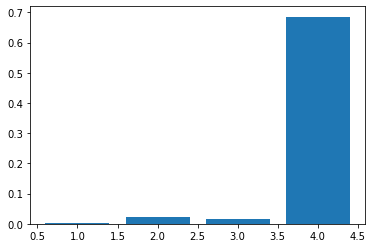

In [98]:
plt.bar(height=s1.values(),x=np.arange(1,5))

In [78]:
new = list(i)
del new[3]
np.anew

[0, 0, 0]

In [85]:
test = [int(j) for j in i]
test

[0, 0, 0, 1]

In [86]:
del test[3]
test

[0, 0, 0]

In [93]:
np.all(test==0)

True

In [92]:
test = np.array(test)

In [88]:
np.all(test == 0)

False

In [79]:
np.all(new==0)

False

In [69]:
new = l
del new[0]
new

[2, 3, 4]

In [61]:
new

array([0, 0, 2], dtype=uint32)

In [19]:
s1,st = sense(4,expansion,uhat)
st

array([0.06402216, 0.02948031, 0.27072989, 0.91190868])

<BarContainer object of 4 artists>

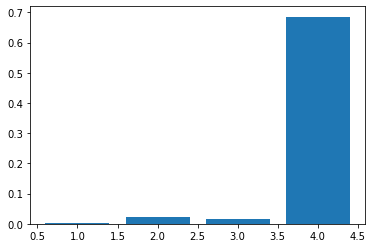

In [22]:
plt.bar(height=s1,x=np.arange(1,5))

<BarContainer object of 4 artists>

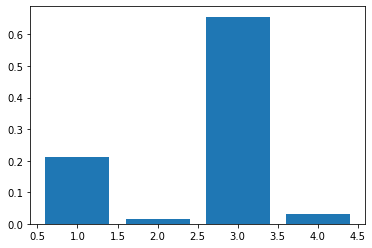

In [36]:
st = ch.Sens_m(poly,joint)
plt.bar(height=st,x=range(1,5))

<BarContainer object of 4 artists>

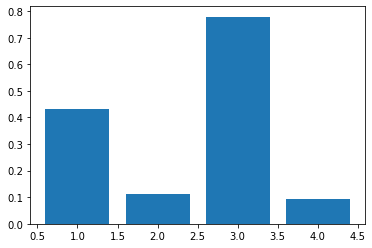

In [14]:
plt.bar(height=gt,x=range(1,5))

In [198]:
## try first order for q_0
s1 = 0
variance = np.sum(uhat[1:]**2)
for idx,term in enumerate(expansion.exponents[1:]):
    if term[2] > 0:
        try:
            s1 += uhat[idx+1]**2
        except:
            pass
        
s1 = s1/variance

s1
    b
    

0.2706638455191029

In [148]:
expansion.indeterminants

polynomial([q0, q1, q2, q3])

In [150]:
for i in expansion:
    print(i)

1.0
270.632938682637*q3-7.848355221796473
7.87295821622217*q2-7.321851141086618
144.33756729740645*q1-4.618802153517007
14.433756729740642*q0-8.08290376865476
81887.25503539266*q3**2-4749.460792052774*q3+67.74914749601533
2130.6818181818176*q2*q3-1981.5340909090905*q3-61.78977272727271*q2+57.46448863636362
69.299627401853*q2**2-128.89730696744658*q2+58.819213751112756
39062.49999999999*q1*q3-1250.0*q3-1132.8124999999998*q1+36.24999999999999
1136.3636363636365*q1*q2-36.36363636363637*q2-1056.818181818182*q1+33.81818181818182
23292.374765622815*q1**2-1490.7119849998603*q1+22.733357771247867
3906.2499999999986*q0*q3-2187.499999999999*q3-113.28124999999996*q0+63.43749999999997
113.63636363636363*q0*q2-63.636363636363626*q2-105.68181818181816*q0+59.18181818181817
2083.333333333333*q0*q1-1166.6666666666665*q1-66.66666666666667*q0+37.33333333333333
232.923747656228*q0**2-260.8745973749754*q0+71.92685327624321


In [180]:
uhat

array([32.7233202 , -3.04494461, 13.73129132,  1.94700908,  7.76485992,
       -0.05936142, -1.45889785, -0.50641919, -0.7071555 , -1.9422552 ,
       -0.68983845, -1.99370389,  3.63766771, -1.10527887, -0.21446448])

In [185]:
a = uhat**2/variance
a

array([3.72437253e+00, 3.22475842e-02, 6.55784509e-01, 1.31848242e-02,
       2.09703482e-01, 1.22559492e-05, 7.40266606e-03, 8.91987345e-04,
       1.73927495e-03, 1.31205179e-02, 1.65513409e-03, 1.38248269e-02,
       4.60240084e-02, 4.24895496e-03, 1.59973902e-04])

In [186]:
ss_1 = a[1:5]
ss_1


array([0.03224758, 0.65578451, 0.01318482, 0.20970348])

In [192]:
st_true = ch.Sens_t(poly,joint)
st_truebbbbb

array([0.27396125, 0.03394871, 0.72322369, 0.05522661])

In [16]:


'''Preamble'''

import numpy as np
import chaospy as ch
from scipy import integrate
import pandas as pd
import time
import json
import pandas as pd
import datetime
import numpoly
from itertools import product
from collections import OrderedDict
import re
import os


def c(s):
    os.chdir(s)
    return os.getcwd()
''''''




x0 = 33                         # Initial conditions same as before
y0 = 6.2
X = [x0,y0]
t = np.linspace(0., 30, 1000)

#Model

def lotka(X, t, alpha, beta, delta, gamma):
    x, y = X
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)
    return np.array([dotx, doty])

#Parameter space

problem = {
    'num_vars': 4,
    'names': ['alpha','beta','delta','gamma'],
    'bounds': [[0.44,0.68],
               [0.02,0.044],
               [0.71,1.15],
               [0.0226,0.0354]]
}
##Parameters
alpha = ch.Uniform(0.44, 0.68) #We choose uniform distributions to reflect our lack of knowledge about the relative likelihood functions
beta = ch.Uniform(0.02, 0.044) #We take the same bounds as for the Sobol-Saltelli analysis
delta = ch.Uniform(0.71, 1.15)
gamma = ch.Uniform(0.0226, 0.0354)

joint = ch.J(alpha,beta,delta,gamma) #The input paramter distributions are assumed to be independent so we may easily construct the joint input probability distribution.



gt_prey = pd.read_csv('./data/indices_328000_GT.csv').ST
gt_norm = np.linalg.norm(gt_prey)


dick = {}

vectors = np.identity(len(joint), dtype='int')

growth=False
recurrence_algorithm='stieltjes'
rule='g'
tolerance=1e-10
scaling=3
n_max=50000


def _construct_lookup(
        orders,
        dists,
        growth,
        recurrence_algorithm,
        rules,
        tolerance,
        scaling,
        n_max,
):
    """
    Create abscissas and weights look-up table so values do not need to be
    re-calculatated on the fly.
    """
    x_lookup = []
    w_lookup = []

    for order, dist in zip(max_order_vector, dists):
        x_lookup.append([])
        w_lookup.append([])
        for orderr in range(max_order + 1):
            (abscissas,), weights = ch.generate_quadrature(
                order=orderr,
                dist=dist,
                growth=growth,
                recurrence_algorithm=recurrence_algorithm,
                rule=rule,
                tolerance=tolerance,
                scaling=scaling,
                n_max=n_max,
            )
            x_lookup[-1].append(abscissas)
            w_lookup[-1].append(weights)
    return x_lookup, w_lookup


def construct_wrapper(maxx):
    global max_order_vector, max_order
    global x_lookup, w_lookup

    max_order = maxx
    max_order_vector = max_order * np.ones(len(joint), dtype=int)
    # print(max_order_vector)

    x_lookup, w_lookup = _construct_lookup(
        orders=max_order_vector,
        dists=joint,
        growth=growth,
        recurrence_algorithm=recurrence_algorithm,
        rules=rule,
        tolerance=tolerance,
        scaling=scaling,
        n_max=5000)

    return x_lookup, w_lookup

x_lookup, w_lookup = construct_wrapper(10)


def generate_candidates(index_set, P):
    global candidates, pre_candidates, back_neighbours

    pre_candidates = []
    candidates = []

    for j in range(0, len(joint)):
        pre_candidates.append(index_set + vectors[j])

    for candidate in pre_candidates:
        back_neighbours = []
        for j in range(0, len(joint)):
            back_neighbour = candidate - vectors[j]
            if np.all((back_neighbour > 1)):
                back_neighbours.append(tuple(back_neighbour))

        if np.all([neighbour in old for neighbour in back_neighbours]):
            candidates.append(tuple(candidate))

    temp = []
    for candidate in candidates:
        # if candidate not in old:
        if np.all(np.array(candidate) <= P) and np.linalg.norm(np.array(candidate),ord=1) <= (P+3):
            temp.append(candidate)

    candidates = temp

    temp = []
    maxx = sum(np.max(np.array(old), axis=0))

    for candidate in candidates:

        if sum(np.max(np.array(old + [candidate]), axis=0)) > maxx:
            temp.append(candidate)

    candidates = temp

    return candidates

def sobol_error(vec):
    return np.linalg.norm(gt_prey - vec) / gt_norm


def solver(old_set,target):

    global poly

    solver_time = time.perf_counter()

    nodes_list = []
    weights_list = []
    evals_list = []

    for index in old_set:
        nodes, weights = build_nodes_weights(index)
        weights = [weight * combinator(index) for weight in weights]

        nodes_list += nodes
        weights_list += weights

    for node in nodes_list:

        if node in dick.keys():
            evals_list.append(dick[node])

        else:
            a, b, d, g = node
            solution = integrate.odeint(lotka, X, t, args=(a, b, d, g)).T[target][910]
            evals_list.append(solution)
            dick[node] = solution

    nodes_list = np.array(nodes_list).T

    polly, uhat = ch.fit_quadrature(expansion, nodes_list, weights_list, evals_list, retall = 1)
    poly.append(polly)
    print('Solver_time >>>', time.perf_counter() - solver_time)
    print('Weight sum >>>', sum(weights_list))
#     print(len(uhat))
    return len(weights_list), uhat


def assign_errors(active_set):
    global active_errors, active, candidates, current_errors, new
    active_errors = []
    
    maxx = sum(np.max(np.array(old), axis=0))

#    for multi_index in active_set:
 #       if (step > 0) and sum(np.max(np.array(old + [multi_index]), axis=0)) <= maxx:
  #          active_set.remove(multi_index)
        

    for multi_index in active_set:
        nodes, _ = build_nodes_weights(multi_index)
        current_errors = []

        for node in nodes:
            a, b, d, g = node
            if np.isnan(poly[-1](a, b, d, g)):
                poly_eval = 0
            else:
                poly_eval = poly[-1](a, b, d, g)

            if node in dick.keys():
                a, b, d, g = node
                current_errors.append(abs(dick[node] - poly_eval))

            else:
                solution = integrate.odeint(lotka, (33, 6.2), t, args=(a, b, d, g)).T[0][910]
                current_errors.append(abs(solution - poly_eval))

        active_errors.append(np.mean(current_errors))

    active = sorted(list(zip(active_set, active_errors)), key=lambda x: x[1])

    return active
    # active = [i for i in OrderedDict((tuple(x[0]), x) for x in active).values()]if np.isnan(poly[-1](1,2,3,4)):

def algorithm(P,species):
    
    global dick, old, candidates, poly, active, global_errors, no_nodes,step,expansion,uhat,exponents
    
    '''Initialise'''
    
    if species == 'prey':
        target = 0
        
    elif species == 'predator':
        target = 1
    
    seed = (2,2,1,2)
    expansion = ch.generate_expansion(P, joint, normed = True)
    exponents = ch.lead_exponent(expansion, graded=True)
    vectors = np.identity(len(joint), dtype='int')
    date_today = datetime.date.today()
    start_time = time.perf_counter()
    
    step = 0
    
    old = [(1,1,1,1)]
    active = []
    poly = []
    
    local_errors = []
    global_errors = []
    
    names = ['alpha','beta','delta','gamma']
    
    df = pd.DataFrame(columns=['chosen_index','local_error','global_error','no_nodes','run_time'])
    df_indices = pd.DataFrame(columns=['alpha','beta','delta','gamma'])
    df_indices_s1 = pd.DataFrame(columns=['alpha','beta','delta','gamma'])

    
    '''Execute zeroth step'''
    
    trivial = [seed]
    number_nodes,uhat = solver(old,target)
    assign_errors(old)
    
    
    st = sense_t(uhat,exponents)
    s1 = sense_main(uhat,exponents)
    
    global_errors.append(sobol_error(st))
    
    print('Global error >>>', global_errors[-1])
    print('Step time >>>', time.perf_counter() - start_time, 'seconds')
    print('-'*10,'break','-'*10)


    '''Main loop'''
    
    while (global_errors[-1] > 0.1 or np.isnan(global_errors[-1])) and len(active)>0:
        
        start_time = time.perf_counter()
        
#         print('Active >>>',active)
        chosen_index = active[-1][0]
        local_errors.append(active[-1][1])
        active.pop()
    
        old.append(chosen_index)
        
        print('Chosen index >>>', chosen_index)
        
        number_nodes,uhat = solver(old,target)
        
        candidates = generate_candidates(chosen_index,P)
        stripped_active = [i[0] for i in active] + [j for j in candidates]
        active = assign_errors(stripped_active)
        
        sobol_time = time.perf_counter() 

        st = sense_t(uhat,exponents)
        s1 = sense_main(uhat,exponents)
        
        print('Sobol time >>>', time.perf_counter() - sobol_time)
        
        global_errors.append(sobol_error(st))

        print('Global error >>>', global_errors[-1])
        
        '''Save data'''
        run_time = time.perf_counter() - start_time
        
        numpoly.savez(f'./data/lotka2/{species}/poly_{P}+{date_today}.npz',*poly)
        
        df_indices = df_indices.append({'alpha': st[0], 'beta': st[1], 'delta': st[2], 'gamma': st[3]          }, ignore_index=True)
        df_indices_s1 = df_indices_s1.append({'alpha': s1[0], 'beta': s1[1], 'delta': s1[2], 'gamma': s1[3]          }, ignore_index=True)
        df = df.append({'chosen_index': chosen_index,'local_error':local_errors[-1],                               'global_error':global_errors[-1],'no_nodes':number_nodes, 'run_time':run_time}, ignore_index=True)
        
        df.to_csv(f'./data/lotka2/{species}/run_file_{P}+{date_today}.csv')
        df_indices.to_csv(f'./data/lotka2/{species}/total_order_indices_{P}+{date_today}.csv')
        df_indices_s1.to_csv(f'./data/lotka2/{species}/first_order_indices_{P}+{date_today}.csv')

        print('Step time >>>', time.perf_counter() - start_time, 'seconds')
        print('-'*10,'break','-'*10)
        
        step += 1
        
    print('Congratulations, the algorithm has converged!')
    print('Here are the results...')
    print('-'*20)
    print(f'ST_alpha:{st[0].round(10)}, ST_beta:{st[1].round(10)}, ST_delta:{st[2].round(10)}, ST_gamma:{st[3].round(10)}')
    print(f'GT_alpha:{gt_prey[0].round(10)}, GT_beta:{gt_prey[1].round(10)}, GT_delta:{gt_prey[2].round(10)}, GT_gamma:{gt_prey[3].round(10)}')
    print(f'The final grid contains {number_nodes} nodes.')
    print(f'The total run time was {df.run_time.sum()}seconds, not bad!')
          

def combinator(current_index):
    coeff = 1
    
    for vector in vectors:
        
        if tuple(np.array(current_index, dtype='int') + vector) in old:
            
            coeff += -1
            
    return coeff 

def build_nodes_weights(current_index):
    
    nodestack = []
    weightstack = []
    
    '''Nodes'''
    
    for index,element in enumerate(current_index):
        nodestack.append([])
        nodestack[index] = list(x_lookup[index][element])
        
    nodes = nodestack[0]
    
    for i in range(1,len(nodestack)):
        nodes = product(nodes,nodestack[i])
        
    nodes = [(a,b,c,d) for (((a,b),c),d) in nodes]
    
    '''Weights'''
    
    for index,element in enumerate(current_index):
        weightstack.append([])
        weightstack[index] = list(w_lookup[index][element])
        
    weights = weightstack[0]
    
    for i in range(1,len(weightstack)):
        weights = product(weights,weightstack[i])
        
    weights = [(a*b*c*d) for (((a,b),c),d) in weights]
    
    
    return nodes,weights

def sense_main(uhat,exponents):

    dim = len(joint)
    s1 = np.zeros(dim)
    
    variance = np.sum(np.array(uhat[1:])**2)
    
    for variable,name in enumerate(expansion.names):
        mask = np.ones(dim)
        mask[variable] = False
        
        for idx,exponent in enumerate(exponents):
            if exponent[variable] > 0 and np.all(exponent*mask == 0):
                s1[variable] += uhat[idx]**2
                
    s1 = s1 / variance
    
    return s1

def sense_t(uhat,exponents):
    
    dim = len(joint)
    st = np.zeros(dim)
    
    variance = np.sum(np.array(uhat[1:])**2)
    
    for variable,name in enumerate(expansion.names):

        mask = np.ones(dim)
        mask[variable] = False
        
        for idx,exponent in enumerate(exponents):
            if exponent[variable] > 0 and np.all(exponent*mask == 0):
                st[variable] += uhat[idx]**2
                
            if exponent[variable] > 0 and np.any(exponent*mask != 0):
                st[variable] += uhat[idx]**2
                
    st = st / variance
    
    return st
    
algorithm(5,'prey')    












Solver_time >>> 0.43555109999999786
Weight sum >>> 0.9999999999999996
Global error >>> 1.0179653394145163
Step time >>> 0.9581157000000076 seconds
---------- break ----------
Chosen index >>> (1, 1, 1, 1)
Solver_time >>> 0.42257580000000416
Weight sum >>> 1.9999999999999996
Sobol time >>> 0.009298199999989265
Global error >>> 1.0179653394145163
Step time >>> 3.3936105000000225 seconds
---------- break ----------
Chosen index >>> (1, 2, 1, 1)
Solver_time >>> 0.22467460000007122
Weight sum >>> 0.9999999999999993
Sobol time >>> 0.01957880000009027
Global error >>> 1.0739818146374238
Step time >>> 7.183743399999912 seconds
---------- break ----------
Chosen index >>> (1, 1, 1, 2)
Solver_time >>> 0.40692999999998847
Weight sum >>> 1.1796119636642288e-16
Sobol time >>> 0.02194320000000971
Global error >>> 1.0506055782680261
Step time >>> 15.381548400000042 seconds
---------- break ----------
Chosen index >>> (2, 1, 1, 2)
Solver_time >>> 0.3041611000001012
Weight sum >>> 8.326672684688674e-17

KeyboardInterrupt: 

In [6]:
uhat

array([-2.51215802e+14, -3.76676812e+14, -9.26068813e+14,  1.13174200e+15,
        3.86247601e+14, -2.05757452e-03, -1.47726533e+15, -7.83541550e-01,
       -3.77421085e+14,  3.63938392e+14,  1.68303844e+14,  4.12578132e+13,
       -4.90728202e-01, -5.75527995e-01,  7.46555536e+14, -4.55439441e+00,
        6.56584169e+14, -1.05723458e+00, -4.62504478e+00, -1.05333381e+13,
       -4.27454198e-01,  2.32880795e+13,  4.66415906e-01,  2.07769947e+01,
       -8.02670210e-01, -8.72289189e-01, -2.79032019e+00,  4.90655428e+13,
        3.67537295e-01, -1.61017016e+01, -1.54840496e+00, -8.46631920e-03,
        4.37570452e+00,  8.25551125e-02, -2.15461753e+02])

In [7]:
a = ch.Sens_t(poly[-1],joint)

In [12]:
a

array([0.49085541, 0.34157522, 0.63178854, 0.19805851])

In [13]:
b

array([0.49085541, 0.34157522, 0.63178854, 0.19805851])

In [14]:
gt_prey

0    0.432888
1    0.111063
2    0.778830
3    0.095090
Name: ST, dtype: float64

In [11]:
b = sense_t(uhat,exponents)